In [0]:
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

pd.set_option('display.max_columns', None)


Notebook objective: to perform eda on the user_info_df and wonky_studies_df

Chart relationships between features that could help determine what features or behavioural patterns that are commmon amungst respondents who are in "wonky_studies" that can allow us to better avoid sending surveys and tasks to individuals who are constantly in studies that under perform.

A study is defined as "wonky" if the outcome is unexpected i.e a decline in the KPI measured when comparing test and control. 

After eda and relationships between features are mapped out. The next goal is to test hypotheses.

### User info EDA

Definitions

user_info_df is a dataframe of respondent x task level database of all users not just those included in "wonky_studies". 

wonky_studies_df is a dataframe of respondents who have been involved in studies where the outcomes were contrary to what we expect i.e the advertisment showed negative impacts of media which is counter intuitive

In [0]:
wonky_studies_df.head()

,respondentPk,task_completed,balance_respondentPk,wonky_task_instances,wonky_unique_tasks,total_wonky_studies,survey_pk,platform_name,hardware_version,yob,survey_locale,exposure_band,wonky_task_ratio,wonky_task_ratio_adj,outlier_volume_users
0,000e79f0-51c6-420a-b0bd-050943840aa7,23,000e79f0-51c6-420a-b0bd-050943840aa7,3,3,3,7z8if,iOS,iPhone,1962,en,exposed,0.130435,0.130435,0
1,00118f00-808b-448a-8e84-114fbe4ac4de,14,00118f00-808b-448a-8e84-114fbe4ac4de,1,1,1,pc11j,Linux,Desktop,1971,en,exposed,0.071429,0.071429,0
2,0037636b-16da-42ce-8d2b-623a7396a8cf,5,0037636b-16da-42ce-8d2b-623a7396a8cf,1,1,1,xzyks,Linux,Desktop,1964,en,exposed,0.200000,0.200000,0
3,00745429-4a9c-49dd-bf3a-84ea4a7d567a,2,00745429-4a9c-49dd-bf3a-84ea4a7d567a,2,2,2,36yi6,Linux,Desktop,1989,en,exposed,1.000000,1.000000,0
4,007a7b66-f3ea-411f-a563-7a943331d64c,35,007a7b66-f3ea-411f-a563-7a943331d64c,1,1,1,dh994,Linux,Desktop,1979,en,control,0.028571,0.028571,0


In [0]:
# loading data

user_info_df = pd.read_parquet(
  "user_info_df_pullcomplete.parquet",
  )

wonky_studies_df = pd.read_parquet(
  "wonky_user_counts_pullcomplete.parquet",
)

print(f"user_info_df: {user_info_df.shape}")
print(f"wonky_studies_df: {wonky_studies_df.shape}")

print(f"Number of unique responses: {user_info_df['respondent_pk'].nunique()}")
print(f"Date range of user_info_df: {user_info_df['date_completed'].min()} - {user_info_df['date_completed'].max()}")

user_info_df: (218323, 266)
wonky_studies_df: (3027, 13)
Number of unique responses: 14407
Date range of user_info_df: 2025-10-10 00:00:11.946000 - 2025-11-16 00:04:55.388000


In [0]:
user_info_df.describe()

,id,version,verified,us_version,quality,risk,system_group_id,up_version,completes,loi,offerwallIndex,payoutPoints,pointsPaid,restarts,taskSequenceId,taskSequenceIndex,task_time_taken,task_completed,wonky_study_flag,yob,task_length_of_task,task_points,wonky_studies_count
count,2.183230e+05,218323.000000,218323.000000,218323.000000,218323.000000,218323.000000,189283.000000,218323.000000,218323.0,2.183230e+05,90232.000000,218323.000000,218323.000000,218323.000000,354.0,218323.000000,2.183230e+05,218323.000000,218323.000000,1093.000000,1093.000000,1093.000000,1093.0
mean,2.315069e+06,11.068096,0.378961,86.034582,82.670273,39.457241,6.155429,19.911191,1.0,7.073913e+01,2.758888,19.667603,19.667603,0.000156,16321457.0,0.001621,4.362046e+03,26.380991,0.257769,1981.091491,3.862763,26.523330,1.0
std,1.096305e+06,6.605527,0.485130,72.273484,29.621687,39.443771,1.357452,27.791991,0.0,7.219790e+03,2.621410,16.884516,16.884516,0.016015,0.0,0.040235,4.382574e+05,17.737731,0.437407,12.724139,0.505840,14.929279,0.0
min,6.400000e+01,2.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,1.0,0.000000e+00,1.000000,5.000000,5.000000,0.000000,16321457.0,0.000000,4.000000e+00,1.000000,0.000000,1935.000000,2.000000,10.000000,1.0
25%,1.687608e+06,7.000000,0.000000,17.000000,70.000000,3.000000,6.000000,8.000000,1.0,1.000000e+00,1.000000,10.000000,10.000000,0.000000,16321457.0,0.000000,8.200000e+01,16.000000,0.000000,1972.000000,4.000000,10.000000,1.0
50%,2.624296e+06,10.000000,0.000000,73.000000,100.000000,33.000000,6.000000,14.000000,1.0,2.000000e+00,2.000000,10.000000,10.000000,0.000000,16321457.0,0.000000,1.570000e+02,24.000000,0.000000,1982.000000,4.000000,40.000000,1.0
75%,3.307948e+06,13.000000,1.000000,142.000000,100.000000,70.000000,6.000000,24.000000,1.0,4.000000e+00,3.000000,40.000000,40.000000,0.000000,16321457.0,0.000000,2.860000e+02,31.000000,1.000000,1990.000000,4.000000,40.000000,1.0
max,3.344792e+06,248.000000,1.000000,376.000000,100.000000,100.000000,10.000000,1243.000000,1.0,1.170309e+06,19.000000,150.000000,150.000000,5.000000,16321457.0,1.000000,7.090605e+07,137.000000,1.000000,2007.000000,4.000000,40.000000,1.0


In [0]:
wonky_studies_df.describe()

,task_completed,wonky_task_instances,wonky_unique_tasks,total_wonky_studies,yob,wonky_task_ratio
count,3027.000000,3027.00000,3027.00000,3027.00000,3027.000000,3027.000000
mean,18.591675,1.48629,1.48629,1.48629,1982.130492,0.152184
std,10.996775,0.85695,0.85695,0.85695,12.319006,0.232245
min,1.000000,1.00000,1.00000,1.00000,1935.000000,0.008772
25%,11.000000,1.00000,1.00000,1.00000,1974.000000,0.047619
50%,19.000000,1.00000,1.00000,1.00000,1983.000000,0.076923
75%,26.000000,2.00000,2.00000,2.00000,1991.000000,0.142857
max,114.000000,9.00000,9.00000,9.00000,2007.000000,3.000000


In [0]:
print("user_info head")
display(user_info_df.head())
print("wonky_studoes_df heead")
display(wonky_studies_df.head())

user_info head


id,version,respondent_pk,username,country,locale,cohort,u_date_created,u_last_updated,enabled,fraud_lock,uninstalled,deleted,main_email,main_email_verified,email,email_verified,verified,us_version,us_date_created,us_last_updated,quality,risk,system_group_id,up_version,up_last_updated,share_location_data,background_location,fine_location,sms_updates,consent3rd_party_cookies,consent_cookies,consent_mobile_device_identifiers,consent_pp_tandc,email_updates,comscore_email,notify_new_task,notify_task_payout,date_completed,date_created,date_expired,date_failed,last_updated,reconciled_last_updated,status,subStatus,amount,callbackUri,completes,exchangeRate,loi,margin,name,offerwallIndex,payoutPoints,pk,pointsPaid,publicDescription,publicTitle,reconciledAmount,reconciledStatus,respondentPk,restarts,taskCategory,taskCountry,taskDescription,taskGroupPk,taskLogo,taskOrigin,taskPk,taskSequenceId,taskSequenceIndex,taskTitle,task_group_pk,classification,buyer,fraudModelVersion,fraudScore,fraudProb,os,appVersion,originMargin,entryPoint,YOB,adfx_starts_last_30_days,age,age_YOB,age_of_children,alcoholFrequency,alcohol_frequency,all_starts_last_30_days,auto_car_brand,auto_car_brand_mc,auto_car_future_purchase,auto_car_manufacture_date,auto_car_purchase_date,auto_car_purchase_type,auto_car_type,auto_car_type_mc,auto_car_use,auto_decision_maker,auto_motorcycle_use,beverageRegularConsumption,beverage_p4w,beverage_p4w_mc,beverage_regular_consumption,beverage_regular_consumption_mc,cellular_plan,children_age_and_gender,children_age_and_gender_mc,children_gender,children_in_household,children_number_in_household,children_yob,clothing_and_homeware_retailer,clothing_and_homeware_retailer_main,clothing_purchase,clothing_purchase_frequency,clothing_retailer_denim,clothing_retailer_denim_main,consumer_traits,device,dma,driver_license,electronics_ownership,electronics_ownership_mc,employee_title,employer_annual_revenue,employer_decision_making_authority,employer_decision_making_authority_mc,employer_department,employer_industry,employer_size,ethnicity,ethnicity_hispanic,exercise_hours,exercise_hours_mc,eyewear,fastfood_frequency,flight_destination,flight_destination_mc,flight_purpose,flight_use,fulcrum_employment_status,fulcrum_ethnicity,fulcrum_household_income,fulcrum_level_of_education,fulcrum_region,fulcrum_social_grade,gambling_bookmakers,gambling_participation,gambling_participation_mc,gaming_device,gaming_device_mc,gaming_hours,gaming_online,gaming_partners,gaming_partners_mc,gaming_platforms,gaming_platforms_mc,gaming_purchase,gaming_subscription_services,gaming_type,gaming_type_mc,gaming_use,gender,grocery_shopper,hobbies,hobbies_mc,holiday_accommodation,holiday_accommodation_mc,home_improvement_category,home_improvement_retailers_kitchen,home_improvement_type,home_owner,homeware_retailer,hotel_use,hotel_use_mc,household_investable_assets,household_other_industry,household_other_industry_mc,household_pets,household_pets_mc,household_type,income_household,income_personal,job_related_activity,job_related_activity_mc,job_title,level_of_education,main_grocery_shop,malaysian_ethnicity,mindshare_age,mindshare_occupation,mobile_operator,movie_frequency,movie_theatre_genre,movie_theatre_genre_mc,nationality,number_in_household,number_of_lightbulbs,occupation,podcast_frequency,postcode,primary_decision_maker,radio_frequency,region,regionOther1,region_city_state,region_level1,region_level2,region_level3,region_nuts1,region_nuts2,region_other1,region_other2,relationship_status,rural_city,smart_tv_brand,smartphone_type,smoking,smoking_frequency,smoking_quit_type,smoking_quit_type_mc,social_media_platforms,social_media_platforms_mc,social_media_use,sports_participation,sports_participation_mc,travel_decision_maker,tvProvider,tv_provider,tv_subscription_services,tv_subscription_services_mc,webcam,webcam_mc,airport_proximity,airport_usage,auto_car_fuel_type,auto_car_usage_frequency,banking_provider,bicycle_usage_frequency,electric_scooter_usage_frequency,public_tr

wonky_studoes_df heead


respondentPk,task_completed,balance_respondentPk,wonky_task_instances,wonky_unique_tasks,total_wonky_studies,survey_pk,platform_name,hardware_version,yob,survey_locale,exposure_band,wonky_task_ratio
000e79f0-51c6-420a-b0bd-050943840aa7,23,000e79f0-51c6-420a-b0bd-050943840aa7,3,3,3,7z8if,iOS,iPhone,1962,en,exposed,0.13043478260869565
00118f00-808b-448a-8e84-114fbe4ac4de,14,00118f00-808b-448a-8e84-114fbe4ac4de,1,1,1,pc11j,Linux,Desktop,1971,en,exposed,0.07142857142857142
0037636b-16da-42ce-8d2b-623a7396a8cf,5,0037636b-16da-42ce-8d2b-623a7396a8cf,1,1,1,xzyks,Linux,Desktop,1964,en,exposed,0.2
00745429-4a9c-49dd-bf3a-84ea4a7d567a,2,00745429-4a9c-49dd-bf3a-84ea4a7d567a,2,2,2,36yi6,Linux,Desktop,1989,en,exposed,1.0
007a7b66-f3ea-411f-a563-7a943331d64c,35,007a7b66-f3ea-411f-a563-7a943331d64c,1,1,1,dh994,Linux,Desktop,1979,en,control,0.02857142857142857


#### Feature engineering

In [0]:
# time related features
user_info_df["hour_of_day"] = user_info_df["date_completed"].dt.hour
user_info_df["day_of_week"] = user_info_df["date_completed"].dt.dayofweek
user_info_df["is_weekend"] = (user_info_df["day_of_week"] > 5).astype(int)
user_info_df["is_night"] = (
    (user_info_df["hour_of_day"] >= 22) | (user_info_df["hour_of_day"] <= 6)
).astype(int)
user_info_df["is_business_hour"] = (
    (user_info_df["hour_of_day"] >= 9) & (user_info_df["hour_of_day"] <= 17)
).astype(int)

# task speed flags (TO CONFIRM WITH DAN ON THESE ESTIMATES - may need greater granularity if hypotheses have ground.)
user_info_df["task_time_minutes"] = user_info_df["task_time_taken"] / 60
user_info_df["is_suspiciously_fast"] = (user_info_df["task_time_taken"] < 30).astype(
    int
)  # <1.5mins
user_info_df["is_very_fast"] = (user_info_df["task_time_taken"] < 3).astype(
    int
)  # <3mins
user_info_df["is_very_slow"] = (user_info_df["task_time_minutes"] > 60).astype(
    int
)  # >1hr

print(
    f"Suspiciously fast (<30s): {user_info_df['is_suspiciously_fast'].sum():,} ({user_info_df['is_suspiciously_fast'].mean()*100:.2f}%)"
)
print(f"Night tasks: {user_info_df['is_night'].mean()*100:.1f}%")
print(f"Weekend tasks: {user_info_df['is_weekend'].mean()*100:.1f}%")

Suspiciously fast (<30s): 12,849 (5.89%)
Night tasks: 10.1%
Weekend tasks: 4.5%


<Axes: >

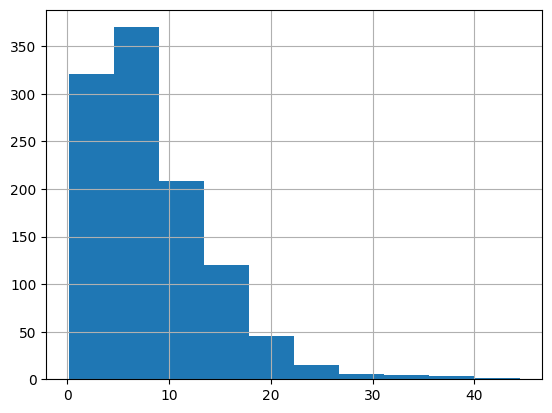

In [0]:
user_info_df['task_points_perMinute'] = user_info_df['task_points'] / user_info_df['task_time_minutes']

user_info_df['task_points_perMinute'].hist()

In [0]:
fig2 = px.histogram(
    user_info_df,
    x="task_completed",
    color="is_suspiciously_fast",
)

fig2.show()

### Respondent EDA

In [0]:
# behavioural features 
user_info_df = user_info_df.sort_values(by=["respondentPk", "date_completed"])

respondent_features = (
    user_info_df.groupby("respondentPk")
    .agg(
        {
            "taskPk": "count",
            "task_time_taken": ["mean", "std", "min", "max", "median"],
            "task_points_perMinute": ["mean", "std", "min", "max", "median"],
            "is_suspiciously_fast": "sum",
            "is_very_fast": "sum",
            "is_night": "sum",
            "is_weekend": "sum",
            "risk": ["mean", "max"],
            "quality": ["mean", "max"],
            "wonky_study_flag": "max",
            "date_completed": ["min", "max"],
        }
    )
    .reset_index()
)

respondent_features.columns = [
    "_".join(col).strip("_") if col[1] else col[0]
    for col in respondent_features.columns.values
]

print(f"Aggregated to {respondent_features.shape[0]:,} respondents")

respondent_features = respondent_features.rename(
    columns={
        "taskPk_count": "total_tasks",
        "task_time_taken_mean": "avg_task_time",
        "task_time_taken_std": "std_task_time",
        "task_time_taken_min": "min_task_time",
        "task_time_taken_max": "max_task_time",
        "task_points_perMinute_mean": "avg_task_pointsPerMin",
        "task_points_perMinute_std": "std_task_pointsPerMin",
        "task_points_perMinute_min": "min_task_pointsPerMin",
        "task_points_perMinute_max": "max_task_pointsPerMin",
        "task_time_taken_median": "median_task_time",
        "is_suspiciously_fast_sum": "suspicious_fast_count",
        "is_very_fast_sum": "very_fast_count",
        "is_night_sum": "night_task_count",
        "is_weekend_sum": "weekend_task_count",
        "risk_mean": "avg_risk",
        "risk_max": "max_risk",
        "quality_mean": "avg_quality",
        "quality_min": "min_quality",
        "wonky_study_flag_max": "wonky_study_flag",
        "date_completed_min": "first_task_date",
        "date_completed_max": "last_task_date",
    }
)

respondent_features["suspicious_fast_rate"] = (
    respondent_features["suspicious_fast_count"] / respondent_features["total_tasks"]
)
respondent_features["very_fast_rate"] = (
    respondent_features["very_fast_count"] / respondent_features["total_tasks"]
)
respondent_features["night_task_rate"] = (
    respondent_features["night_task_count"] / respondent_features["total_tasks"]
)
respondent_features["weekend_task_rate"] = (
    respondent_features["weekend_task_count"] / respondent_features["total_tasks"]
)

respondent_features["task_time_cv"] = respondent_features[
    "std_task_time"
] / respondent_features["avg_task_time"].replace(0, np.nan) # closer to 0 more stable.

respondent_features["task_ppm_cv"] = respondent_features[
    "std_task_pointsPerMin"
] / respondent_features["avg_task_pointsPerMin"].replace(0, np.nan) # closer to 0 more stable.

respondent_features["days_active"] = (
    respondent_features["last_task_date"] - respondent_features["first_task_date"]
).dt.days + 1
respondent_features["tasks_per_day"] = (
    respondent_features["total_tasks"] / respondent_features["days_active"]
)

print(f"Created derived behavioral features")
print(f"Avg tasks per respondent: {respondent_features['total_tasks'].mean():.2f}")
print(
    f"Avg suspicious fast rate: {respondent_features['suspicious_fast_rate'].mean()*100:.2f}%"
)

points_perMin_thresh = respondent_features["avg_task_pointsPerMin"].quantile(0.95)
high_vol_thresh = respondent_features["total_tasks"].quantile(0.95)
extreme_vol_thresh = respondent_features["total_tasks"].quantile(0.99)

respondent_features["is_high_pointsPerMinute"] = (
    respondent_features["avg_task_pointsPerMin"] > high_vol_thresh
).astype(int)
respondent_features["is_high_volume"] = (
    respondent_features["total_tasks"] > high_vol_thresh
).astype(int)
respondent_features["is_extreme_volume"] = (
    respondent_features["total_tasks"] > extreme_vol_thresh
).astype(int)

respondent_features["velocity_tier"] = pd.cut(
    respondent_features["tasks_per_day"],
    bins=[0, 1, 3, 5, 10, np.inf],
    labels=["Very_Low", "Low", "Medium", "High", "Very_High"],
)

respondent_features["velocity_tier(pointsPerMinute)"] = pd.cut(
    respondent_features["avg_task_pointsPerMin"],
    bins=[0, 1, 3, 5, 10, np.inf],
    labels=["Very_Low", "Low", "Medium", "High", "Very_High"],
)

print(f"High volume threshold (95th): {high_vol_thresh:.0f} tasks")
print(
    f"High volume users: {respondent_features['is_high_volume'].sum():,} ({respondent_features['is_high_volume'].mean()*100:.1f}%)"
)

display(respondent_features.head())

Aggregated to 14,407 respondents
Created derived behavioral features
Avg tasks per respondent: 15.15
Avg suspicious fast rate: 4.62%
High volume threshold (95th): 35 tasks
High volume users: 717 (5.0%)


respondentPk,total_tasks,avg_task_time,std_task_time,min_task_time,max_task_time,median_task_time,avg_task_pointsPerMin,std_task_pointsPerMin,min_task_pointsPerMin,max_task_pointsPerMin,task_points_perMinute_median,suspicious_fast_count,very_fast_count,night_task_count,weekend_task_count,avg_risk,max_risk,avg_quality,quality_max,wonky_study_flag,first_task_date,last_task_date,suspicious_fast_rate,very_fast_rate,night_task_rate,weekend_task_rate,task_time_cv,task_ppm_cv,days_active,tasks_per_day,is_high_pointsPerMinute,is_high_volume,is_extreme_volume,velocity_tier,velocity_tier(pointsPerMinute)
00026000-9d75-494e-8ae0-ad7d9fe3d14e,4,721.5,1156.709269148187,121,2456,154.5,null,null,null,null,null,0,0,0,0,70.0,70.0,50.0,50.0,0,2025-10-11T13:08:27.883Z,2025-10-13T11:03:45.504Z,0.0,0.0,0.0,0.0,1.6032006502400376,null,2,2.0,0,0,0,Low,null
000718f3-ad7c-431d-b064-31ac22a3249e,5,64.6,30.761989532538365,22,99,69.0,null,null,null,null,null,1,0,0,0,0.0,0.0,100.0,100.0,0,2025-10-15T20:20:21.516Z,2025-10-27T19:00:05.369Z,0.2,0.0,0.0,0.0,0.4761917884293865,null,12,0.4166666666666667,0,0,0,Very_Low,null
00081f4e-c434-472c-975d-4278cf3c7fe7,13,910.2307692307693,1690.6202586548993,25,4922,169.0,null,null,null,null,null,1,0,0,0,100.0,100.0,100.0,100.0,0,2025-10-11T09:05:56.914Z,2025-11-03T15:51:06.742Z,0.07692307692307693,0.0,0.0,0.0,1.857353449041975,null,24,0.5416666666666666,0,0,0,Very_Low,null
00083e76-37fa-4a71-9964-3d8b46c5d7b6,17,155.52941176470588,61.68986712485571,36,302,143.0,null,null,null,null,null,0,0,0,4,100.0,100.0,70.0,70.0,0,2025-10-31T14:54:36.456Z,2025-11-04T18:56:54.529Z,0.0,0.0,0.0,0.23529411764705882,0.3966443801522493,null,5,3.4,0,0,0,Medium,null
000ca3cb-168c-415d-8549-6f239ee48675,25,377.64,325.192876100733,51,1161,284.0,null,null,null,null,null,0,0,7,1,70.0,70.0,10.0,10.0,0,2025-10-29T11:51:31.62Z,2025-11-14T18:26:41.778Z,0.0,0.0,0.28,0.04,0.8611187270965284,null,17,1.4705882352941178,0,0,0,Low,null


In [0]:
# involvement in wonky studies
respondent_features = respondent_features.merge(
    wonky_studies_df[['respondentPk', 'wonky_task_instances', 'wonky_unique_tasks',
                  'total_wonky_studies', 'wonky_task_ratio']],
    on='respondentPk',
    how='left'
)

respondent_features[['wonky_task_instances', 'wonky_unique_tasks', 
                     'total_wonky_studies', 'wonky_task_ratio']] = (
    respondent_features[['wonky_task_instances', 'wonky_unique_tasks', 
                        'total_wonky_studies', 'wonky_task_ratio']].fillna(0)
)

respondent_features['wonky_concentration'] = pd.cut(
    respondent_features['wonky_task_ratio'],
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    labels=['Very_Low', 'Low', 'Medium', 'High', 'Very_High'],
    include_lowest=True
)

respondent_features['is_high_wonky'] = (respondent_features['wonky_task_ratio'] > 0.5).astype(int)
respondent_features['is_quite_wonky'] = (respondent_features['wonky_task_ratio'] > 0.3).astype(int)
respondent_features['wonky_diversity'] = (respondent_features['wonky_unique_tasks'] / 
                                           respondent_features['wonky_task_instances'].replace(0, np.nan))

print(f"Wonky features added")
print(f"Respondents with wonky tasks: {(respondent_features['wonky_task_ratio'] > 0).sum():,}")
print(f"High wonky concentration (>50%): {respondent_features['is_high_wonky'].sum():,}")
print(f"Quite wonky concentration (>50%): {respondent_features['is_quite_wonky'].sum():,}")

Wonky features added
Respondents with wonky tasks: 3,027
High wonky concentration (>50%): 123
Quite wonky concentration (>50%): 322


In [0]:
# Quality-Risk blend flags
respondent_features['bad_quality_high_risk'] = (
    (respondent_features['avg_risk'] > 0.5) & 
    (respondent_features['avg_quality'] < 0.5)
).astype(int)

respondent_features['good_quality_low_risk'] = (
    (respondent_features['avg_risk'] < 0.3) & 
    (respondent_features['avg_quality'] > 0.7)
).astype(int)

# Multi-factor fraud score (0-10 scale)
respondent_features['fraud_risk_score'] = (
    respondent_features['is_high_volume'] * 2 +
    (respondent_features['suspicious_fast_rate'] > 0.3).astype(int) * 2 +
    respondent_features['is_high_wonky'].astype(int) * 2 +
    (respondent_features['avg_risk'] > 0.5).astype(int) * 1 +
    (respondent_features['task_time_cv'] < 0.2).astype(int) * 1 +
    (respondent_features['night_task_rate'] > 0.5).astype(int) * 1 +
    (respondent_features['tasks_per_day'] > 10).astype(int) * 1
)

# Fraud risk tiers
respondent_features['fraud_risk_tier'] = pd.cut(
    respondent_features['fraud_risk_score'],
    bins=[0, 2, 4, 6, 10],
    labels=['Low', 'Medium', 'High', 'Critical'],
    include_lowest=True
)

# Suspected fraud label (for hypothesis testing)
respondent_features['suspected_fraud'] = (respondent_features['fraud_risk_score'] >= 6).astype(int)

print("Fraud risk distribution:")
print(respondent_features['fraud_risk_tier'].value_counts().sort_index())
print(f"Suspected fraud rate: {respondent_features['suspected_fraud'].mean()*100:.2f}%")



Fraud risk distribution:
Low         13407
Medium        995
High            5
Critical        0
Name: fraud_risk_tier, dtype: int64
Suspected fraud rate: 0.00%


In [0]:
fig_avg_ppm = px.histogram(
    respondent_features,
    x="avg_task_pointsPerMin",
    nbins=50,
    marginal="box",
    title="Distribution of Points per Min per Responded",
    labels={"avg_task_pointsPerMin": "Average Points Per Minute"},
)
fig_avg_ppm.update_layout(bargap=0.1)

In [0]:
fig_avg_time = px.histogram(
    respondent_features,
    x="avg_task_time",
    nbins=50,
    marginal="box",
    title="Distribution of Average Task Time per Respondent",
    labels={"avg_task_time": "Average Task Time (sec)"},
)
fig_avg_time.update_layout(bargap=0.1)

In [0]:
fig_cv = px.histogram(
    respondent_features,
    x="task_time_cv",
    nbins=50,
    marginal="box",
    title="Distribution of Task Time Coefficient of Variation (CV) per Respondent",
    labels={"task_time_cv": "Task Time CV"},
)
fig_cv.update_layout(bargap=0.1)

# standard deviation / mean >> bigger number = more variation in task time.

In [0]:
fig_cv = px.histogram(
    respondent_features,
    x="task_ppm_cv",
    nbins=50,
    marginal="box",
    title="Distribution of Task Time Coefficient of Variation (CV) per Respondent",
    labels={"task_ppm_cv": "Task PPM"},
)
fig_cv.update_layout(bargap=0.1)

# standard deviation / mean >> bigger number = more variation in task time.

In [0]:
fig = px.histogram(respondent_features, x='fraud_risk_score',
                   color='fraud_risk_tier',
                   title='Fraud Risk Score Distribution',
                   labels={'fraud_risk_score': 'Fraud Risk Score (0-10)'})
fig.show()

### Wonky Studies DF -> focus on wonky studies

In [0]:
wonky_studies_df.head(2)

,respondentPk,task_completed,balance_respondentPk,wonky_task_instances,wonky_unique_tasks,total_wonky_studies,survey_pk,platform_name,hardware_version,yob,survey_locale,exposure_band,wonky_task_ratio,wonky_task_ratio_adj,outlier_volume_users
0,000e79f0-51c6-420a-b0bd-050943840aa7,23,000e79f0-51c6-420a-b0bd-050943840aa7,3,3,3,7z8if,iOS,iPhone,1962,en,exposed,0.130435,0.130435,0
1,00118f00-808b-448a-8e84-114fbe4ac4de,14,00118f00-808b-448a-8e84-114fbe4ac4de,1,1,1,pc11j,Linux,Desktop,1971,en,exposed,0.071429,0.071429,0


In [0]:
wonky_studies_df["wonky_task_ratio_adj"] = np.where(
    wonky_studies_df["wonky_task_ratio"] > 1, 1, wonky_studies_df["wonky_task_ratio"]
)

In [0]:
fig1 = px.scatter(
    wonky_studies_df,
    x="task_completed",
    y="wonky_task_ratio_adj",
    title="Task Completed vs Wonky Rate",
    labels={
        "task_completed": "Task Completed",
        "wonky_rate": "Wonky Rate",
    },
    hover_data=["respondentPk"],
)

fig1.show()

In [0]:
task_distributon = wonky_studies_df["task_completed"].describe()
high_volume_threshold = wonky_studies_df["task_completed"].quantile(0.95)
high_volume_users = wonky_studies_df[
    wonky_studies_df["task_completed"] > high_volume_threshold
]

wonky_studies_df["outlier_volume_users"] = np.where(
    wonky_studies_df["task_completed"] > high_volume_threshold, 1, 0)

task_distributon

count    3027.000000
mean       18.591675
std        10.996775
min         1.000000
25%        11.000000
50%        19.000000
75%        26.000000
max       114.000000
Name: task_completed, dtype: float64

In [0]:
fig2 = px.histogram(
    wonky_studies_df,
    x="task_completed",
    color="outlier_volume_users",
)

fig2.show()

In [0]:
wonky_studies_df

,respondentPk,task_completed,balance_respondentPk,wonky_task_instances,wonky_unique_tasks,total_wonky_studies,survey_pk,platform_name,hardware_version,yob,survey_locale,exposure_band,wonky_task_ratio,wonky_task_ratio_adj,outlier_volume_users
0,000e79f0-51c6-420a-b0bd-050943840aa7,23,000e79f0-51c6-420a-b0bd-050943840aa7,3,3,3,7z8if,iOS,iPhone,1962,en,exposed,0.130435,0.130435,0
1,00118f00-808b-448a-8e84-114fbe4ac4de,14,00118f00-808b-448a-8e84-114fbe4ac4de,1,1,1,pc11j,Linux,Desktop,1971,en,exposed,0.071429,0.071429,0
2,0037636b-16da-42ce-8d2b-623a7396a8cf,5,0037636b-16da-42ce-8d2b-623a7396a8cf,1,1,1,xzyks,Linux,Desktop,1964,en,exposed,0.200000,0.200000,0
3,00745429-4a9c-49dd-bf3a-84ea4a7d567a,2,00745429-4a9c-49dd-bf3a-84ea4a7d567a,2,2,2,36yi6,Linux,Desktop,1989,en,exposed,1.000000,1.000000,0
4,007a7b66-f3ea-411f-a563-7a943331d64c,35,007a7b66-f3ea-411f-a563-7a943331d64c,1,1,1,dh994,Linux,Desktop,1979,en,control,0.028571,0.028571,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3022,ff72d0a6-28a0-4bdb-961f-87a34d8a6a99,10,ff72d0a6-28a0-4bdb-961f-87a34d8a6a99,1,1,1,fidw3,Linux,Desktop,1960,en,control,0.100000,0.100000,0
3023,ffc18a41-9a03-47a9-be09-0a54916fae33,24,ffc18a41-9a03-47a9-be09-0a54916fae33,2,2,2,trkw4,Linux,Desktop,1974,en,control,0.083333,0.083333,0
3024,ffc7cc68-4c68-402f-a255-09b892d56ba3,5,ffc7cc68-4c68-402f-a255-09b892d56ba3,1,1,1,pc11j,iOS,iPhone,1992,en,control,0.200000,0.200000,0
3025,ffda0275-bee3-4cb4-8521-e0206e6786d5,23,ffda0275-bee3-4cb4-8521-e0206e6786d5,1,1,1,98ddw,Linux,Desktop,1990,en,exposed,0.043478,0.043478,0


In [0]:
fig2 = px.histogram(
    wonky_studies_df,
    x="task_completed",
    color="is_quite_wonky",
)

fig2.show()

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File <command-6040630712158941>, line 1
----> 1 fig2 = px.histogram(
      2     wonky_studies_df,
      3     x="task_completed",
      4     color="is_quite_wonky",
      5 )
      7 fig2.show()

File /databricks/python/lib/python3.12/site-packages/plotly/express/_chart_types.py:480, in histogram(data_frame, x, y, color, pattern_shape, facet_row, facet_col, facet_col_wrap, facet_row_spacing, facet_col_spacing, hover_name, hover_data, animation_frame, animation_group, category_orders, labels, color_discrete_sequence, color_discrete_map, pattern_shape_sequence, pattern_shape_map, marginal, opacity, orientation, barmode, barnorm, histnorm, log_x, log_y, range_x, range_y, histfunc, cumulative, nbins, text_auto, title, template, width, height)
    434 def histogram(
    435     data_frame=None,
    436     x=None,
   (...)
    472     heig

In [0]:
fig2 = px.histogram(
    wonky_studies_df,
    x="points",
    color="outlier_volume_users",
)

fig2.show()

In [0]:
sorted(user_info_df.columns)

['YOB',
 'adfx_starts_last_30_days',
 'age',
 'age_YOB',
 'age_of_children',
 'airport_proximity',
 'airport_usage',
 'alcoholFrequency',
 'alcohol_frequency',
 'all_starts_last_30_days',
 'amount',
 'appVersion',
 'auto_car_brand',
 'auto_car_brand_mc',
 'auto_car_fuel_type',
 'auto_car_future_purchase',
 'auto_car_manufacture_date',
 'auto_car_purchase_date',
 'auto_car_purchase_type',
 'auto_car_type',
 'auto_car_type_mc',
 'auto_car_usage_frequency',
 'auto_car_use',
 'auto_decision_maker',
 'auto_motorcycle_use',
 'background_location',
 'balance_respondentPk',
 'banking_provider',
 'beverageRegularConsumption',
 'beverage_p4w',
 'beverage_p4w_mc',
 'beverage_regular_consumption',
 'beverage_regular_consumption_mc',
 'bicycle_usage_frequency',
 'buyer',
 'callbackUri',
 'cellular_plan',
 'children_age_and_gender',
 'children_age_and_gender_mc',
 'children_gender',
 'children_in_household',
 'children_number_in_household',
 'children_yob',
 'classification',
 'clothing_and_homeware

In [0]:
break

In [0]:
fig2 = px.histogram(
    wonky_studies_df,
    x="task_completed",
    color="outlier_volume_users",
    title="Wonky Rate by High Volume Users (95% have <= 82 tasks il_30 days)",
)

fig2.show()

### Hypothesis Testing

In [0]:
# Create binary flag for wonky users
respondent_features['has_wonky_tasks'] = (respondent_features['wonky_task_ratio'] > 0).astype(int)

print(f"Wonky users: {respondent_features['has_wonky_tasks'].sum():,} ({respondent_features['has_wonky_tasks'].mean()*100:.2f}%)")
print(f"Non-wonky users: {(respondent_features['has_wonky_tasks'] == 0).sum():,} ({(respondent_features['has_wonky_tasks'] == 0).mean()*100:.2f}%)")


#### Comparative EDA: Wonky vs Non-Wonky Users

Comparing behavioral patterns between users who have been in wonky studies vs those who haven't.


In [ ]:
# Summary statistics comparison
comparison_cols = [
    'avg_task_time', 'suspicious_fast_rate', 'total_tasks', 'tasks_per_day',
    'task_time_cv', 'task_ppm_cv', 'avg_quality', 'avg_risk',
    'night_task_rate', 'weekend_task_rate', 'avg_task_pointsPerMin'
]

comparison_stats = respondent_features.groupby('has_wonky_tasks')[comparison_cols].agg(['mean', 'median', 'std'])
print("Summary Statistics: Wonky vs Non-Wonky Users")
print("=" * 80)
display(comparison_stats)


In [ ]:
# Task completion speed comparison
fig_speed = px.box(
    respondent_features,
    x='has_wonky_tasks',
    y='avg_task_time',
    color='has_wonky_tasks',
    title='Average Task Time: Wonky vs Non-Wonky Users',
    labels={'has_wonky_tasks': 'Has Wonky Tasks (1=Yes, 0=No)', 'avg_task_time': 'Average Task Time (seconds)'},
    category_orders={'has_wonky_tasks': [0, 1]}
)
fig_speed.update_traces(boxmean='sd')
fig_speed.show()

fig_suspicious_rate = px.histogram(
    respondent_features,
    x='suspicious_fast_rate',
    color='has_wonky_tasks',
    nbins=50,
    barmode='overlay',
    opacity=0.7,
    title='Suspicious Fast Rate Distribution: Wonky vs Non-Wonky',
    labels={'suspicious_fast_rate': 'Suspicious Fast Rate', 'has_wonky_tasks': 'Has Wonky Tasks'}
)
fig_suspicious_rate.show()


In [ ]:
# Task volume comparison
fig_volume = px.box(
    respondent_features,
    x='has_wonky_tasks',
    y='total_tasks',
    color='has_wonky_tasks',
    title='Total Tasks: Wonky vs Non-Wonky Users',
    labels={'has_wonky_tasks': 'Has Wonky Tasks (1=Yes, 0=No)', 'total_tasks': 'Total Tasks'},
    category_orders={'has_wonky_tasks': [0, 1]}
)
fig_volume.update_traces(boxmean='sd')
fig_volume.show()

fig_tasks_per_day = px.box(
    respondent_features,
    x='has_wonky_tasks',
    y='tasks_per_day',
    color='has_wonky_tasks',
    title='Tasks Per Day: Wonky vs Non-Wonky Users',
    labels={'has_wonky_tasks': 'Has Wonky Tasks (1=Yes, 0=No)', 'tasks_per_day': 'Tasks Per Day'},
    category_orders={'has_wonky_tasks': [0, 1]}
)
fig_tasks_per_day.update_traces(boxmean='sd')
fig_tasks_per_day.show()


In [ ]:
# Consistency metrics comparison
fig_cv_time = px.box(
    respondent_features,
    x='has_wonky_tasks',
    y='task_time_cv',
    color='has_wonky_tasks',
    title='Task Time Coefficient of Variation: Wonky vs Non-Wonky',
    labels={'has_wonky_tasks': 'Has Wonky Tasks (1=Yes, 0=No)', 'task_time_cv': 'Task Time CV'},
    category_orders={'has_wonky_tasks': [0, 1]}
)
fig_cv_time.update_traces(boxmean='sd')
fig_cv_time.show()

fig_cv_ppm = px.box(
    respondent_features,
    x='has_wonky_tasks',
    y='task_ppm_cv',
    color='has_wonky_tasks',
    title='Task Points Per Minute CV: Wonky vs Non-Wonky',
    labels={'has_wonky_tasks': 'Has Wonky Tasks (1=Yes, 0=No)', 'task_ppm_cv': 'Task PPM CV'},
    category_orders={'has_wonky_tasks': [0, 1]}
)
fig_cv_ppm.update_traces(boxmean='sd')
fig_cv_ppm.show()


In [ ]:
# Quality and Risk scores comparison
fig_quality = px.box(
    respondent_features,
    x='has_wonky_tasks',
    y='avg_quality',
    color='has_wonky_tasks',
    title='Average Quality Score: Wonky vs Non-Wonky Users',
    labels={'has_wonky_tasks': 'Has Wonky Tasks (1=Yes, 0=No)', 'avg_quality': 'Average Quality'},
    category_orders={'has_wonky_tasks': [0, 1]}
)
fig_quality.update_traces(boxmean='sd')
fig_quality.show()

fig_risk = px.box(
    respondent_features,
    x='has_wonky_tasks',
    y='avg_risk',
    color='has_wonky_tasks',
    title='Average Risk Score: Wonky vs Non-Wonky Users',
    labels={'has_wonky_tasks': 'Has Wonky Tasks (1=Yes, 0=No)', 'avg_risk': 'Average Risk'},
    category_orders={'has_wonky_tasks': [0, 1]}
)
fig_risk.update_traces(boxmean='sd')
fig_risk.show()


In [ ]:
# Temporal patterns comparison
fig_night = px.box(
    respondent_features,
    x='has_wonky_tasks',
    y='night_task_rate',
    color='has_wonky_tasks',
    title='Night Task Rate: Wonky vs Non-Wonky Users',
    labels={'has_wonky_tasks': 'Has Wonky Tasks (1=Yes, 0=No)', 'night_task_rate': 'Night Task Rate'},
    category_orders={'has_wonky_tasks': [0, 1]}
)
fig_night.update_traces(boxmean='sd')
fig_night.show()

fig_weekend = px.box(
    respondent_features,
    x='has_wonky_tasks',
    y='weekend_task_rate',
    color='has_wonky_tasks',
    title='Weekend Task Rate: Wonky vs Non-Wonky Users',
    labels={'has_wonky_tasks': 'Has Wonky Tasks (1=Yes, 0=No)', 'weekend_task_rate': 'Weekend Task Rate'},
    category_orders={'has_wonky_tasks': [0, 1]}
)
fig_weekend.update_traces(boxmean='sd')
fig_weekend.show()


#### Demographic and Platform Feature Analysis


In [ ]:
# Merge demographic features from wonky_studies_df
demographic_cols = ['respondentPk', 'platform_name', 'hardware_version', 'yob', 
                     'survey_locale', 'exposure_band']

respondent_features = respondent_features.merge(
    wonky_studies_df[demographic_cols].drop_duplicates(subset=['respondentPk']),
    on='respondentPk',
    how='left'
)

# Calculate age from year of birth (assuming current year is 2025 based on data range)
current_year = 2025
respondent_features['age'] = current_year - respondent_features['yob']
respondent_features['age'] = respondent_features['age'].clip(lower=0, upper=120)  # reasonable bounds

print(f"Demographic features merged")
print(f"Platforms: {respondent_features['platform_name'].nunique()}")
print(f"Hardware versions: {respondent_features['hardware_version'].nunique()}")
print(f"Locales: {respondent_features['survey_locale'].nunique()}")
print(f"Exposure bands: {respondent_features['exposure_band'].nunique()}")


In [ ]:
# Wonky rates by platform
platform_wonky = respondent_features.groupby('platform_name').agg({
    'has_wonky_tasks': ['sum', 'count', 'mean'],
    'wonky_task_ratio': 'mean'
}).reset_index()
platform_wonky.columns = ['platform_name', 'wonky_count', 'total_count', 'wonky_rate', 'avg_wonky_ratio']
platform_wonky = platform_wonky.sort_values('wonky_rate', ascending=False)

print("Wonky Rates by Platform:")
print("=" * 80)
display(platform_wonky)

fig_platform = px.bar(
    platform_wonky,
    x='platform_name',
    y='wonky_rate',
    title='Wonky Rate by Platform',
    labels={'platform_name': 'Platform', 'wonky_rate': 'Wonky Rate'},
    color='wonky_rate',
    color_continuous_scale='Reds'
)
fig_platform.update_xaxes(tickangle=45)
fig_platform.show()


In [ ]:
# Wonky rates by hardware version
hardware_wonky = respondent_features.groupby('hardware_version').agg({
    'has_wonky_tasks': ['sum', 'count', 'mean'],
    'wonky_task_ratio': 'mean'
}).reset_index()
hardware_wonky.columns = ['hardware_version', 'wonky_count', 'total_count', 'wonky_rate', 'avg_wonky_ratio']
hardware_wonky = hardware_wonky.sort_values('wonky_rate', ascending=False)

print("Wonky Rates by Hardware Version (Top 10):")
print("=" * 80)
display(hardware_wonky.head(10))

fig_hardware = px.bar(
    hardware_wonky.head(15),
    x='hardware_version',
    y='wonky_rate',
    title='Wonky Rate by Hardware Version (Top 15)',
    labels={'hardware_version': 'Hardware Version', 'wonky_rate': 'Wonky Rate'},
    color='wonky_rate',
    color_continuous_scale='Reds'
)
fig_hardware.update_xaxes(tickangle=45)
fig_hardware.show()


In [ ]:
# Wonky rates by survey locale
locale_wonky = respondent_features.groupby('survey_locale').agg({
    'has_wonky_tasks': ['sum', 'count', 'mean'],
    'wonky_task_ratio': 'mean'
}).reset_index()
locale_wonky.columns = ['survey_locale', 'wonky_count', 'total_count', 'wonky_rate', 'avg_wonky_ratio']
locale_wonky = locale_wonky.sort_values('wonky_rate', ascending=False)

print("Wonky Rates by Survey Locale:")
print("=" * 80)
display(locale_wonky)

fig_locale = px.bar(
    locale_wonky,
    x='survey_locale',
    y='wonky_rate',
    title='Wonky Rate by Survey Locale',
    labels={'survey_locale': 'Survey Locale', 'wonky_rate': 'Wonky Rate'},
    color='wonky_rate',
    color_continuous_scale='Reds'
)
fig_locale.update_xaxes(tickangle=45)
fig_locale.show()


In [ ]:
# Wonky rates by exposure band
exposure_wonky = respondent_features.groupby('exposure_band').agg({
    'has_wonky_tasks': ['sum', 'count', 'mean'],
    'wonky_task_ratio': 'mean'
}).reset_index()
exposure_wonky.columns = ['exposure_band', 'wonky_count', 'total_count', 'wonky_rate', 'avg_wonky_ratio']
exposure_wonky = exposure_wonky.sort_values('wonky_rate', ascending=False)

print("Wonky Rates by Exposure Band:")
print("=" * 80)
display(exposure_wonky)

fig_exposure = px.bar(
    exposure_wonky,
    x='exposure_band',
    y='wonky_rate',
    title='Wonky Rate by Exposure Band',
    labels={'exposure_band': 'Exposure Band', 'wonky_rate': 'Wonky Rate'},
    color='wonky_rate',
    color_continuous_scale='Reds'
)
fig_exposure.update_xaxes(tickangle=45)
fig_exposure.show()


In [ ]:
# Age distribution comparison
fig_age = px.histogram(
    respondent_features.dropna(subset=['age']),
    x='age',
    color='has_wonky_tasks',
    nbins=30,
    barmode='overlay',
    opacity=0.7,
    title='Age Distribution: Wonky vs Non-Wonky Users',
    labels={'age': 'Age', 'has_wonky_tasks': 'Has Wonky Tasks'}
)
fig_age.show()

# Age bins analysis
respondent_features['age_bin'] = pd.cut(
    respondent_features['age'],
    bins=[0, 25, 35, 45, 55, 65, 120],
    labels=['<25', '25-34', '35-44', '45-54', '55-64', '65+']
)

age_wonky = respondent_features.groupby('age_bin').agg({
    'has_wonky_tasks': ['sum', 'count', 'mean'],
    'wonky_task_ratio': 'mean'
}).reset_index()
age_wonky.columns = ['age_bin', 'wonky_count', 'total_count', 'wonky_rate', 'avg_wonky_ratio']
age_wonky = age_wonky.dropna()

print("Wonky Rates by Age Group:")
print("=" * 80)
display(age_wonky)

fig_age_bin = px.bar(
    age_wonky,
    x='age_bin',
    y='wonky_rate',
    title='Wonky Rate by Age Group',
    labels={'age_bin': 'Age Group', 'wonky_rate': 'Wonky Rate'},
    color='wonky_rate',
    color_continuous_scale='Reds'
)
fig_age_bin.show()


In [ ]:
# Platform-Hardware combination heatmap
platform_hardware = respondent_features.groupby(['platform_name', 'hardware_version']).agg({
    'has_wonky_tasks': ['sum', 'count', 'mean']
}).reset_index()
platform_hardware.columns = ['platform_name', 'hardware_version', 'wonky_count', 'total_count', 'wonky_rate']
platform_hardware = platform_hardware[platform_hardware['total_count'] >= 10]  # Filter for meaningful sample sizes
platform_hardware = platform_hardware.sort_values('wonky_rate', ascending=False)

print("Top Platform-Hardware Combinations by Wonky Rate (min 10 users):")
print("=" * 80)
display(platform_hardware.head(20))

# Create pivot table for heatmap
pivot_data = platform_hardware.pivot_table(
    values='wonky_rate',
    index='platform_name',
    columns='hardware_version',
    aggfunc='mean'
)

fig_heatmap = px.imshow(
    pivot_data,
    title='Wonky Rate Heatmap: Platform x Hardware Version',
    labels=dict(x='Hardware Version', y='Platform', color='Wonky Rate'),
    color_continuous_scale='Reds',
    aspect='auto'
)
fig_heatmap.update_xaxes(tickangle=45)
fig_heatmap.show()


#### Statistical Hypothesis Testing


In [ ]:
# Perform Mann-Whitney U tests for key metrics
wonky_users = respondent_features[respondent_features['has_wonky_tasks'] == 1]
non_wonky_users = respondent_features[respondent_features['has_wonky_tasks'] == 0]

test_metrics = [
    'avg_task_time', 'suspicious_fast_rate', 'total_tasks', 'tasks_per_day',
    'task_time_cv', 'task_ppm_cv', 'avg_quality', 'avg_risk',
    'night_task_rate', 'weekend_task_rate', 'avg_task_pointsPerMin'
]

statistical_results = []

for metric in test_metrics:
    wonky_values = wonky_users[metric].dropna()
    non_wonky_values = non_wonky_users[metric].dropna()
    
    if len(wonky_values) > 0 and len(non_wonky_values) > 0:
        statistic, p_value = mannwhitneyu(wonky_values, non_wonky_values, alternative='two-sided')
        
        # Calculate effect size (Cohen's d approximation using rank-based method)
        wonky_median = wonky_values.median()
        non_wonky_median = non_wonky_values.median()
        median_diff = wonky_median - non_wonky_median
        
        statistical_results.append({
            'metric': metric,
            'wonky_median': wonky_median,
            'non_wonky_median': non_wonky_median,
            'median_difference': median_diff,
            'wonky_mean': wonky_values.mean(),
            'non_wonky_mean': non_wonky_values.mean(),
            'statistic': statistic,
            'p_value': p_value,
            'significant': p_value < 0.05
        })

statistical_df = pd.DataFrame(statistical_results)
statistical_df = statistical_df.sort_values('p_value')

print("Statistical Test Results (Mann-Whitney U Test):")
print("=" * 100)
display(statistical_df)


In [ ]:
# Visualize significant differences
significant_metrics = statistical_df[statistical_df['significant'] == True]['metric'].tolist()

if len(significant_metrics) > 0:
    print(f"\nSignificant differences found in {len(significant_metrics)} metrics:")
    for metric in significant_metrics:
        row = statistical_df[statistical_df['metric'] == metric].iloc[0]
        direction = "higher" if row['median_difference'] > 0 else "lower"
        print(f"  - {metric}: Wonky users have {direction} values (p={row['p_value']:.4f})")
else:
    print("\nNo significant differences found at p < 0.05")

# Create visualization of significant differences
if len(significant_metrics) > 0:
    fig_sig = make_subplots(
        rows=(len(significant_metrics) + 1) // 2,
        cols=2,
        subplot_titles=significant_metrics,
        vertical_spacing=0.15
    )
    
    for idx, metric in enumerate(significant_metrics[:6]):  # Limit to 6 for readability
        row = (idx // 2) + 1
        col = (idx % 2) + 1
        
        fig_sig.add_trace(
            go.Box(
                y=wonky_users[metric].dropna(),
                name='Wonky',
                marker_color='red',
                boxmean='sd'
            ),
            row=row, col=col
        )
        
        fig_sig.add_trace(
            go.Box(
                y=non_wonky_users[metric].dropna(),
                name='Non-Wonky',
                marker_color='blue',
                boxmean='sd'
            ),
            row=row, col=col
        )
    
    fig_sig.update_layout(
        title='Significant Differences: Wonky vs Non-Wonky Users',
        height=300 * ((len(significant_metrics) + 1) // 2),
        showlegend=False
    )
    fig_sig.show()


#### Correlation and Pattern Analysis


In [ ]:
# Correlation matrix: wonky_task_ratio vs behavioral features
correlation_features = [
    'wonky_task_ratio', 'avg_task_time', 'suspicious_fast_rate', 'total_tasks',
    'tasks_per_day', 'task_time_cv', 'task_ppm_cv', 'avg_quality', 'avg_risk',
    'night_task_rate', 'weekend_task_rate', 'avg_task_pointsPerMin',
    'fraud_risk_score', 'suspicious_fast_count', 'very_fast_rate'
]

corr_data = respondent_features[correlation_features].corr()['wonky_task_ratio'].sort_values(ascending=False)
corr_data = corr_data.drop('wonky_task_ratio')

print("Correlation with Wonky Task Ratio:")
print("=" * 80)
display(corr_data)

fig_corr = px.bar(
    x=corr_data.index,
    y=corr_data.values,
    title='Correlation of Features with Wonky Task Ratio',
    labels={'x': 'Feature', 'y': 'Correlation Coefficient'},
    color=corr_data.values,
    color_continuous_scale='RdBu',
    color_continuous_midpoint=0
)
fig_corr.update_xaxes(tickangle=45)
fig_corr.show()


In [ ]:
# Scatter plots: key relationships
fig_scatter_volume = px.scatter(
    respondent_features,
    x='total_tasks',
    y='wonky_task_ratio',
    color='has_wonky_tasks',
    title='Task Volume vs Wonky Task Ratio',
    labels={'total_tasks': 'Total Tasks', 'wonky_task_ratio': 'Wonky Task Ratio'},
    opacity=0.6,
    trendline='ols'
)
fig_scatter_volume.show()

fig_scatter_speed = px.scatter(
    respondent_features,
    x='suspicious_fast_rate',
    y='wonky_task_ratio',
    color='has_wonky_tasks',
    title='Suspicious Fast Rate vs Wonky Task Ratio',
    labels={'suspicious_fast_rate': 'Suspicious Fast Rate', 'wonky_task_ratio': 'Wonky Task Ratio'},
    opacity=0.6,
    trendline='ols'
)
fig_scatter_speed.show()

fig_scatter_quality = px.scatter(
    respondent_features,
    x='avg_quality',
    y='wonky_task_ratio',
    color='has_wonky_tasks',
    title='Average Quality vs Wonky Task Ratio',
    labels={'avg_quality': 'Average Quality', 'wonky_task_ratio': 'Wonky Task Ratio'},
    opacity=0.6,
    trendline='ols'
)
fig_scatter_quality.show()


In [ ]:
# Identify threshold values where wonky rates increase significantly
# Analyze wonky rates across different bins of key features

def analyze_thresholds(feature, bins=10):
    """Analyze wonky rates across feature bins"""
    df = respondent_features.copy()
    df[f'{feature}_bin'] = pd.qcut(df[feature].rank(method='first'), q=bins, duplicates='drop')
    
    threshold_analysis = df.groupby(f'{feature}_bin').agg({
        'has_wonky_tasks': ['sum', 'count', 'mean'],
        'wonky_task_ratio': 'mean',
        feature: ['min', 'max', 'mean']
    }).reset_index()
    
    threshold_analysis.columns = [
        'bin', 'wonky_count', 'total_count', 'wonky_rate', 'avg_wonky_ratio',
        'min_val', 'max_val', 'mean_val'
    ]
    
    return threshold_analysis

# Analyze thresholds for key features
print("Threshold Analysis: Task Volume")
print("=" * 80)
volume_thresholds = analyze_thresholds('total_tasks', bins=10)
display(volume_thresholds)

print("\nThreshold Analysis: Suspicious Fast Rate")
print("=" * 80)
speed_thresholds = analyze_thresholds('suspicious_fast_rate', bins=10)
display(speed_thresholds)

print("\nThreshold Analysis: Average Quality")
print("=" * 80)
quality_thresholds = analyze_thresholds('avg_quality', bins=10)
display(quality_thresholds)


In [ ]:
# Visualize threshold effects
fig_volume_thresh = px.bar(
    volume_thresholds,
    x='mean_val',
    y='wonky_rate',
    title='Wonky Rate by Task Volume Bins',
    labels={'mean_val': 'Average Total Tasks in Bin', 'wonky_rate': 'Wonky Rate'},
    color='wonky_rate',
    color_continuous_scale='Reds',
    text='total_count'
)
fig_volume_thresh.update_traces(texttemplate='%{text}', textposition='outside')
fig_volume_thresh.show()

fig_speed_thresh = px.bar(
    speed_thresholds,
    x='mean_val',
    y='wonky_rate',
    title='Wonky Rate by Suspicious Fast Rate Bins',
    labels={'mean_val': 'Average Suspicious Fast Rate in Bin', 'wonky_rate': 'Wonky Rate'},
    color='wonky_rate',
    color_continuous_scale='Reds',
    text='total_count'
)
fig_speed_thresh.update_traces(texttemplate='%{text}', textposition='outside')
fig_speed_thresh.show()


#### Hypothesis Formulation

Based on the EDA findings, the following hypotheses are proposed for testing:


**H1: Task Completion Speed Hypothesis**

- **Null Hypothesis (H0)**: There is no difference in suspicious fast completion rates between wonky and non-wonky users.
- **Alternative Hypothesis (H1)**: Wonky users have higher suspicious fast completion rates than non-wonky users.
- **Test Method**: Mann-Whitney U test (already performed)
- **Expected Direction**: Wonky users will show higher suspicious_fast_rate
- **Rationale**: Users who complete tasks too quickly may not be engaging properly, leading to unexpected study outcomes.


**H2: Task Volume Hypothesis**

- **Null Hypothesis (H0)**: There is no relationship between total task volume and wonky study participation.
- **Alternative Hypothesis (H1)**: High-volume users are more likely to participate in wonky studies.
- **Test Method**: Correlation analysis and threshold analysis (already performed)
- **Expected Direction**: Positive correlation between total_tasks and wonky_task_ratio
- **Rationale**: Users who complete many tasks may develop patterns that lead to unexpected responses or may be gaming the system.


**H3: Platform-Hardware Combination Hypothesis**

- **Null Hypothesis (H0)**: Platform and hardware version combinations do not affect wonky study rates.
- **Alternative Hypothesis (H1)**: Specific platform-hardware combinations are associated with higher wonky rates.
- **Test Method**: Chi-square test or ANOVA on platform-hardware combinations
- **Expected Direction**: Certain combinations will show significantly higher wonky rates
- **Rationale**: Technical factors (device type, OS version) may affect user experience and response quality.


**H4: Task Consistency Hypothesis**

- **Null Hypothesis (H0)**: Task time variability (CV) does not differ between wonky and non-wonky users.
- **Alternative Hypothesis (H1)**: Wonky users show either extremely low or extremely high task time variability.
- **Test Method**: Mann-Whitney U test on task_time_cv (already performed)
- **Expected Direction**: Wonky users may show either very low CV (too consistent/robotic) or very high CV (inconsistent behavior)
- **Rationale**: Unusual consistency patterns may indicate automated behavior, while high inconsistency may indicate poor engagement.


**H5: Quality-Risk Score Hypothesis**

- **Null Hypothesis (H0)**: Quality and risk scores do not predict wonky study participation.
- **Alternative Hypothesis (H1)**: Users with low quality scores and/or high risk scores are more likely to be in wonky studies.
- **Test Method**: Mann-Whitney U tests on avg_quality and avg_risk (already performed)
- **Expected Direction**: Wonky users will have lower avg_quality and/or higher avg_risk
- **Rationale**: Quality and risk scores are designed to identify problematic users; these should correlate with wonky outcomes.


**H6: Temporal Pattern Hypothesis**

- **Null Hypothesis (H0)**: Temporal patterns (night/weekend task rates) do not differ between wonky and non-wonky users.
- **Alternative Hypothesis (H1)**: Wonky users show different temporal activity patterns (e.g., higher night task rates).
- **Test Method**: Mann-Whitney U tests on night_task_rate and weekend_task_rate (already performed)
- **Expected Direction**: Wonky users may show higher night_task_rate (indicating unusual activity patterns)
- **Rationale**: Unusual timing patterns may indicate bot behavior or users in different time zones gaming the system.


**H7: Demographic Factors Hypothesis**

- **Null Hypothesis (H0)**: Demographic factors (age, locale, exposure band) do not affect wonky study rates.
- **Alternative Hypothesis (H1)**: Specific demographic segments show higher wonky rates.
- **Test Method**: Chi-square tests or ANOVA on demographic categories
- **Expected Direction**: Certain age groups, locales, or exposure bands will show higher wonky rates
- **Rationale**: Different user segments may have different engagement levels or response patterns that affect study outcomes.


In [ ]:
# Summary of hypothesis test results
print("Hypothesis Testing Summary")
print("=" * 80)
print("\nH1: Task Completion Speed")
h1_result = statistical_df[statistical_df['metric'] == 'suspicious_fast_rate']
if len(h1_result) > 0:
    h1 = h1_result.iloc[0]
    print(f"  Result: {'REJECT H0' if h1['significant'] else 'FAIL TO REJECT H0'} (p={h1['p_value']:.4f})")
    print(f"  Wonky users have {'higher' if h1['median_difference'] > 0 else 'lower'} suspicious fast rate")
else:
    print("  Test not performed")

print("\nH4: Task Consistency")
h4_result = statistical_df[statistical_df['metric'] == 'task_time_cv']
if len(h4_result) > 0:
    h4 = h4_result.iloc[0]
    print(f"  Result: {'REJECT H0' if h4['significant'] else 'FAIL TO REJECT H0'} (p={h4['p_value']:.4f})")
    print(f"  Wonky users have {'higher' if h4['median_difference'] > 0 else 'lower'} task time CV")
else:
    print("  Test not performed")

print("\nH5: Quality-Risk Scores")
h5_quality = statistical_df[statistical_df['metric'] == 'avg_quality']
h5_risk = statistical_df[statistical_df['metric'] == 'avg_risk']
if len(h5_quality) > 0:
    h5q = h5_quality.iloc[0]
    print(f"  Quality: {'REJECT H0' if h5q['significant'] else 'FAIL TO REJECT H0'} (p={h5q['p_value']:.4f})")
    print(f"    Wonky users have {'higher' if h5q['median_difference'] > 0 else 'lower'} quality")
if len(h5_risk) > 0:
    h5r = h5_risk.iloc[0]
    print(f"  Risk: {'REJECT H0' if h5r['significant'] else 'FAIL TO REJECT H0'} (p={h5r['p_value']:.4f})")
    print(f"    Wonky users have {'higher' if h5r['median_difference'] > 0 else 'lower'} risk")

print("\nH6: Temporal Patterns")
h6_night = statistical_df[statistical_df['metric'] == 'night_task_rate']
h6_weekend = statistical_df[statistical_df['metric'] == 'weekend_task_rate']
if len(h6_night) > 0:
    h6n = h6_night.iloc[0]
    print(f"  Night Rate: {'REJECT H0' if h6n['significant'] else 'FAIL TO REJECT H0'} (p={h6n['p_value']:.4f})")
if len(h6_weekend) > 0:
    h6w = h6_weekend.iloc[0]
    print(f"  Weekend Rate: {'REJECT H0' if h6w['significant'] else 'FAIL TO REJECT H0'} (p={h6w['p_value']:.4f})")

print("\nH2: Task Volume Correlation")
h2_corr = corr_data.get('total_tasks', None)
if h2_corr is not None:
    print(f"  Correlation: {h2_corr:.4f}")
    print(f"  {'Positive correlation found' if h2_corr > 0 else 'Negative correlation found'}")
else:
    print("  Correlation not calculated")


In [ ]:
# Interaction features
respondent_features['high_volume_x_suspicious_fast'] = (
    respondent_features['is_high_volume'] * 
    (respondent_features['suspicious_fast_rate'] > 0.3).astype(int)
).astype(int)

respondent_features['low_quality_x_high_risk'] = (
    (respondent_features['avg_quality'] < 0.5).astype(int) * 
    (respondent_features['avg_risk'] > 0.5).astype(int)
).astype(int)

respondent_features['high_volume_x_low_quality'] = (
    respondent_features['is_high_volume'] * 
    (respondent_features['avg_quality'] < 0.5).astype(int)
).astype(int)

# Composite wonky risk score (0-10 scale)
respondent_features['wonky_risk_score'] = (
    (respondent_features['suspicious_fast_rate'] > 0.3).astype(int) * 2 +
    respondent_features['is_high_volume'].astype(int) * 2 +
    (respondent_features['avg_quality'] < 0.5).astype(int) * 2 +
    (respondent_features['avg_risk'] > 0.5).astype(int) * 1 +
    (respondent_features['task_time_cv'] < 0.2).astype(int) * 1 +
    (respondent_features['night_task_rate'] > 0.5).astype(int) * 1 +
    (respondent_features['tasks_per_day'] > 10).astype(int) * 1
)

respondent_features['wonky_risk_tier'] = pd.cut(
    respondent_features['wonky_risk_score'],
    bins=[0, 2, 4, 6, 10],
    labels=['Low', 'Medium', 'High', 'Critical'],
    include_lowest=True
)

print("Advanced features created")
print(f"High volume × Suspicious fast: {respondent_features['high_volume_x_suspicious_fast'].sum():,}")
print(f"Low quality × High risk: {respondent_features['low_quality_x_high_risk'].sum():,}")
print(f"\nWonky Risk Score Distribution:")
print(respondent_features['wonky_risk_tier'].value_counts().sort_index())

# Analyze wonky rates by risk tier
wonky_by_risk = respondent_features.groupby('wonky_risk_tier').agg({
    'has_wonky_tasks': ['sum', 'count', 'mean'],
    'wonky_task_ratio': 'mean'
}).reset_index()
wonky_by_risk.columns = ['risk_tier', 'wonky_count', 'total_count', 'wonky_rate', 'avg_wonky_ratio']
print("\nWonky Rates by Risk Tier:")
display(wonky_by_risk)


In [ ]:
# Visualize wonky risk score effectiveness
fig_wonky_risk = px.bar(
    wonky_by_risk,
    x='risk_tier',
    y='wonky_rate',
    title='Wonky Rate by Wonky Risk Tier',
    labels={'risk_tier': 'Wonky Risk Tier', 'wonky_rate': 'Wonky Rate'},
    color='wonky_rate',
    color_continuous_scale='Reds',
    text='total_count'
)
fig_wonky_risk.update_traces(texttemplate='%{text}', textposition='outside')
fig_wonky_risk.show()

fig_wonky_risk_dist = px.histogram(
    respondent_features,
    x='wonky_risk_score',
    color='has_wonky_tasks',
    nbins=11,
    barmode='overlay',
    opacity=0.7,
    title='Wonky Risk Score Distribution: Wonky vs Non-Wonky Users',
    labels={'wonky_risk_score': 'Wonky Risk Score', 'has_wonky_tasks': 'Has Wonky Tasks'}
)
fig_wonky_risk_dist.show()


#### Additional Feature Analysis: Exposure Band and Survey-Level Patterns


In [ ]:
# Analyze wonky rates by exposure band (test vs control)
exposure_analysis = respondent_features.groupby('exposure_band').agg({
    'has_wonky_tasks': ['sum', 'count', 'mean'],
    'wonky_task_ratio': 'mean',
    'total_tasks': 'mean',
    'avg_quality': 'mean',
    'avg_risk': 'mean'
}).reset_index()

exposure_analysis.columns = ['exposure_band', 'wonky_count', 'total_count', 'wonky_rate', 
                             'avg_wonky_ratio', 'avg_total_tasks', 'avg_quality', 'avg_risk']
exposure_analysis = exposure_analysis.dropna(subset=['exposure_band'])

print("Wonky Rates by Exposure Band (Test vs Control):")
print("=" * 80)
display(exposure_analysis)

if len(exposure_analysis) > 0:
    fig_exposure_detail = px.bar(
        exposure_analysis,
        x='exposure_band',
        y='wonky_rate',
        title='Wonky Rate by Exposure Band',
        labels={'exposure_band': 'Exposure Band', 'wonky_rate': 'Wonky Rate'},
        color='wonky_rate',
        color_continuous_scale='Reds',
        text='total_count'
    )
    fig_exposure_detail.update_traces(texttemplate='%{text}', textposition='outside')
    fig_exposure_detail.show()


In [ ]:
# Analyze wonky rates by survey (survey_pk)
survey_analysis = respondent_features.groupby('survey_pk').agg({
    'has_wonky_tasks': ['sum', 'count', 'mean'],
    'wonky_task_ratio': 'mean',
    'total_tasks': 'mean'
}).reset_index()

survey_analysis.columns = ['survey_pk', 'wonky_count', 'total_count', 'wonky_rate', 
                          'avg_wonky_ratio', 'avg_total_tasks']
survey_analysis = survey_analysis.dropna(subset=['survey_pk'])
survey_analysis = survey_analysis.sort_values('wonky_rate', ascending=False)

print("Top 20 Surveys by Wonky Rate:")
print("=" * 80)
display(survey_analysis.head(20))

if len(survey_analysis) > 0:
    fig_survey = px.bar(
        survey_analysis.head(20),
        x='survey_pk',
        y='wonky_rate',
        title='Wonky Rate by Survey (Top 20)',
        labels={'survey_pk': 'Survey ID', 'wonky_rate': 'Wonky Rate'},
        color='wonky_rate',
        color_continuous_scale='Reds',
        text='total_count'
    )
    fig_survey.update_xaxes(tickangle=45)
    fig_survey.update_traces(texttemplate='%{text}', textposition='outside')
    fig_survey.show()


In [ ]:
# Merge additional behavioral features from user_info_df
behavioral_cols_to_merge = ['respondentPk', 'restarts', 'loi', 'taskCategory', 
                            'task_targeting_type', 'task_category', 'wonky_studies_count']

# Get aggregated behavioral features at respondent level
behavioral_agg = user_info_df.groupby('respondentPk').agg({
    'restarts': ['sum', 'mean'],
    'loi': ['mean', 'max'],
    'taskCategory': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,
    'task_category': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,
    'task_targeting_type': lambda x: x.mode()[0] if len(x.mode()) > 0 else None,
    'wonky_studies_count': 'max'
}).reset_index()

behavioral_agg.columns = [
    'respondentPk', 'total_restarts', 'avg_restarts', 'avg_loi', 'max_loi',
    'most_common_taskCategory', 'most_common_task_category', 
    'most_common_targeting_type', 'max_wonky_studies_count'
]

respondent_features = respondent_features.merge(
    behavioral_agg,
    on='respondentPk',
    how='left'
)

print("Behavioral features merged")
print(f"Respondents with restarts: {(respondent_features['total_restarts'] > 0).sum():,}")
print(f"Average LOI: {respondent_features['avg_loi'].mean():.2f}")
print(f"Task categories: {respondent_features['most_common_task_category'].value_counts().head()}")


In [ ]:
# Analyze restarts pattern: wonky vs non-wonky
restart_analysis = respondent_features.groupby('has_wonky_tasks').agg({
    'total_restarts': ['mean', 'median', 'sum'],
    'avg_restarts': 'mean',
    'avg_loi': 'mean'
}).reset_index()

restart_analysis.columns = ['has_wonky_tasks', 'mean_total_restarts', 'median_total_restarts', 
                            'sum_total_restarts', 'mean_avg_restarts', 'mean_avg_loi']

print("Restart Patterns: Wonky vs Non-Wonky Users")
print("=" * 80)
display(restart_analysis)

fig_restarts = px.box(
    respondent_features.dropna(subset=['total_restarts']),
    x='has_wonky_tasks',
    y='total_restarts',
    color='has_wonky_tasks',
    title='Total Restarts: Wonky vs Non-Wonky Users',
    labels={'has_wonky_tasks': 'Has Wonky Tasks (1=Yes, 0=No)', 'total_restarts': 'Total Restarts'},
    category_orders={'has_wonky_tasks': [0, 1]}
)
fig_restarts.update_traces(boxmean='sd')
fig_restarts.show()

fig_loi = px.box(
    respondent_features.dropna(subset=['avg_loi']),
    x='has_wonky_tasks',
    y='avg_loi',
    color='has_wonky_tasks',
    title='Average Length of Interview (LOI): Wonky vs Non-Wonky Users',
    labels={'has_wonky_tasks': 'Has Wonky Tasks (1=Yes, 0=No)', 'avg_loi': 'Average LOI'},
    category_orders={'has_wonky_tasks': [0, 1]}
)
fig_loi.update_traces(boxmean='sd')
fig_loi.show()


In [ ]:
# Analyze task category patterns
task_cat_analysis = respondent_features.groupby('most_common_task_category').agg({
    'has_wonky_tasks': ['sum', 'count', 'mean'],
    'wonky_task_ratio': 'mean'
}).reset_index()

task_cat_analysis.columns = ['task_category', 'wonky_count', 'total_count', 'wonky_rate', 'avg_wonky_ratio']
task_cat_analysis = task_cat_analysis.dropna(subset=['task_category'])
task_cat_analysis = task_cat_analysis.sort_values('wonky_rate', ascending=False)

print("Wonky Rates by Task Category:")
print("=" * 80)
display(task_cat_analysis)

if len(task_cat_analysis) > 0:
    fig_task_cat = px.bar(
        task_cat_analysis,
        x='task_category',
        y='wonky_rate',
        title='Wonky Rate by Task Category',
        labels={'task_category': 'Task Category', 'wonky_rate': 'Wonky Rate'},
        color='wonky_rate',
        color_continuous_scale='Reds',
        text='total_count'
    )
    fig_task_cat.update_traces(texttemplate='%{text}', textposition='outside')
    fig_task_cat.show()


In [ ]:
# Statistical test for restarts and LOI
restart_wonky = respondent_features[respondent_features['has_wonky_tasks'] == 1]['total_restarts'].dropna()
restart_non_wonky = respondent_features[respondent_features['has_wonky_tasks'] == 0]['total_restarts'].dropna()

loi_wonky = respondent_features[respondent_features['has_wonky_tasks'] == 1]['avg_loi'].dropna()
loi_non_wonky = respondent_features[respondent_features['has_wonky_tasks'] == 0]['avg_loi'].dropna()

if len(restart_wonky) > 0 and len(restart_non_wonky) > 0:
    restart_stat, restart_p = mannwhitneyu(restart_wonky, restart_non_wonky, alternative='two-sided')
    print(f"Restarts: Mann-Whitney U test")
    print(f"  Statistic: {restart_stat:.2f}, p-value: {restart_p:.4f}")
    print(f"  Wonky median: {restart_wonky.median():.2f}, Non-wonky median: {restart_non_wonky.median():.2f}")
    print(f"  {'Significant' if restart_p < 0.05 else 'Not significant'} difference")

if len(loi_wonky) > 0 and len(loi_non_wonky) > 0:
    loi_stat, loi_p = mannwhitneyu(loi_wonky, loi_non_wonky, alternative='two-sided')
    print(f"\nLOI: Mann-Whitney U test")
    print(f"  Statistic: {loi_stat:.2f}, p-value: {loi_p:.4f}")
    print(f"  Wonky median: {loi_wonky.median():.2f}, Non-wonky median: {loi_non_wonky.median():.2f}")
    print(f"  {'Significant' if loi_p < 0.05 else 'Not significant'} difference")


#### Summary of Key Findings

Based on the comprehensive EDA and hypothesis testing:


In [ ]:
# Create summary of key patterns
print("=" * 80)
print("KEY FINDINGS SUMMARY")
print("=" * 80)

print("\n1. Behavioral Patterns:")
if len(statistical_df) > 0:
    sig_metrics = statistical_df[statistical_df['significant'] == True]
    if len(sig_metrics) > 0:
        print(f"   - {len(sig_metrics)} behavioral metrics show significant differences")
        for _, row in sig_metrics.head(5).iterrows():
            direction = "higher" if row['median_difference'] > 0 else "lower"
            print(f"     * {row['metric']}: Wonky users have {direction} values (p={row['p_value']:.4f})")
    else:
        print("   - No significant behavioral differences found")

print("\n2. Demographic Patterns:")
if 'platform_name' in respondent_features.columns:
    platform_sig = platform_wonky[platform_wonky['wonky_rate'] > platform_wonky['wonky_rate'].median()]
    print(f"   - Platform analysis: {len(platform_sig)} platforms above median wonky rate")
if 'age_bin' in respondent_features.columns:
    age_sig = age_wonky[age_wonky['wonky_rate'] > age_wonky['wonky_rate'].median()]
    print(f"   - Age analysis: {len(age_sig)} age groups above median wonky rate")

print("\n3. Risk Score Effectiveness:")
if 'wonky_risk_tier' in respondent_features.columns:
    risk_summary = wonky_by_risk.sort_values('wonky_rate', ascending=False)
    print(f"   - Highest risk tier wonky rate: {risk_summary.iloc[-1]['wonky_rate']:.2%}")
    print(f"   - Lowest risk tier wonky rate: {risk_summary.iloc[0]['wonky_rate']:.2%}")

print("\n4. Correlation Insights:")
if len(corr_data) > 0:
    top_corr = corr_data.head(3)
    print(f"   - Top 3 positive correlations with wonky_task_ratio:")
    for idx, val in top_corr.items():
        print(f"     * {idx}: {val:.4f}")

print("\n5. Recommendations for Further Analysis:")
print("   - Investigate specific platform-hardware combinations with high wonky rates")
print("   - Analyze survey-level patterns to identify problematic study designs")
print("   - Build predictive model using wonky_risk_score and demographic features")
print("   - Test intervention strategies for high-risk user segments")
